<a href="https://colab.research.google.com/github/Ayshashafeek/kakkathollayiram/blob/main/Kakkathollayiram_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import os, cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# CHANGE THESE if needed:
positive_dir = "/content/drive/MyDrive/STAR/positive/positive"
negative_dir = "/content/drive/MyDrive/STAR/negative/negative"

X, y = [], []

def load_images(folder, label):
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (32, 32))
            X.append(img)
            y.append(label)

load_images(positive_dir, 1)
load_images(negative_dir, 0)

X = np.array(X).astype("float32") / 255.0  # normalize
X = X.reshape(-1, 32, 32, 1)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.6427 - loss: 0.5328 - val_accuracy: 0.9764 - val_loss: 0.3075
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9712 - loss: 0.2965 - val_accuracy: 0.9921 - val_loss: 0.1602
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0686 - val_accuracy: 0.9921 - val_loss: 0.0704
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0148 - val_accuracy: 0.9921 - val_loss: 0.0683
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9921 - val_loss: 0.0850
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9921 - val_loss: 0.0939
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9921 - val_loss: 0.1297
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1425e-04 - val_accuracy: 0.9921 - val_loss: 0.13

In [47]:
def predict_patch(patch):
    patch = cv2.resize(patch, (32, 32))
    patch = patch.astype("float32") / 255.0
    patch = patch.reshape(1, 32, 32, 1)
    prediction = model.predict(patch, verbose=0)
    return np.argmax(prediction)


In [38]:
def sliding_window(image, step, size):
    win_w, win_h = size
    for y in range(0, image.shape[0] - win_h + 1, step):
        for x in range(0, image.shape[1] - win_w + 1, step):
            yield (x, y, image[y:y+win_h, x:x+win_w])

In [39]:
import cv2

image_path = "/content/drive/MyDrive/STAR/test7.jpg"
full_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if full_image is None:
    raise FileNotFoundError(f"❌ Image not found at {image_path}")
else:
    print("✅ Image loaded successfully!", full_image.shape)


✅ Image loaded successfully! (800, 1280)


In [40]:
if full_image is None:
    print("❌ Image not loaded. Please check the image path and file.")
else:
    patches = []
    centers = []

    for (x, y, window) in sliding_window(full_image, 16, (32, 32)):
        if window.shape != (32, 32):
            continue
        window = window.astype("float32") / 255.0
        patches.append(window)
        centers.append((x + 16, y + 16))  # center point of the window

    # Convert to numpy array
    patches = np.array(patches)
    patches = patches.reshape(-1, 32, 32, 1)

    # Run batch prediction
    predictions = model.predict(patches, verbose=1)
    labels = np.argmax(predictions, axis=1)

    # Filter detected coordinates
    detected_coords = [center for center, label in zip(centers, labels) if label == 1]

    print(f"✅ Detected {len(detected_coords)} potential star patches")

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Detected 512 potential star patches


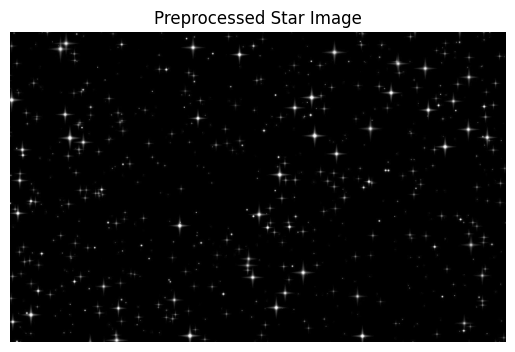

In [48]:
import cv2
import matplotlib.pyplot as plt

# Load the image (you just uploaded it)
image_path = "/content/drive/MyDrive/STAR/test7.jpg"

# Load in grayscale
full_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Enhance contrast (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
full_image = clahe.apply(full_image)

# Preview the image
plt.imshow(full_image, cmap="gray")
plt.title("Preprocessed Star Image")
plt.axis("off")
plt.show()


In [49]:
patches = []
centers = []

for (x, y, window) in sliding_window(full_image, 16, (32, 32)):
    if window.shape != (32, 32):
        continue
    window = window.astype("float32") / 255.0
    patches.append(window)
    centers.append((x + 16, y + 16))  # center of patch

patches = np.array(patches).reshape(-1, 32, 32, 1)

# Predict all patches in one go
preds = model.predict(patches, verbose=1)
labels = np.argmax(preds, axis=1)

# Keep only detected stars
detected_coords = [center for center, label in zip(centers, labels) if label == 1]
print(f"✅ Raw detections: {len(detected_coords)}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Raw detections: 542


🌟 Final star count (after clustering): 542


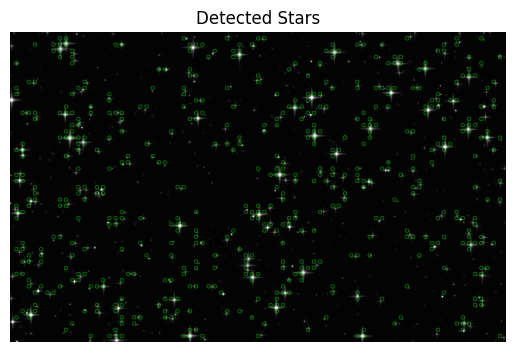

In [50]:
from sklearn.cluster import DBSCAN
import numpy as np

if len(detected_coords) > 0:
    coords_array = np.array(detected_coords)
    clustering = DBSCAN(eps=10, min_samples=1).fit(coords_array)

    unique_centers = []
    labels = clustering.labels_

    for label in np.unique(labels):
        cluster_points = coords_array[labels == label]
        mean_point = cluster_points.mean(axis=0).astype(int)
        unique_centers.append(tuple(mean_point))

    print(f"🌟 Final star count (after clustering): {len(unique_centers)}")

    # Draw results
    output_img = cv2.cvtColor(full_image, cv2.COLOR_GRAY2BGR)
    for (x, y) in unique_centers:
        cv2.circle(output_img, (x, y), 5, (0, 255, 0), 1)

    plt.imshow(output_img)
    plt.title("Detected Stars")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ No stars detected.")


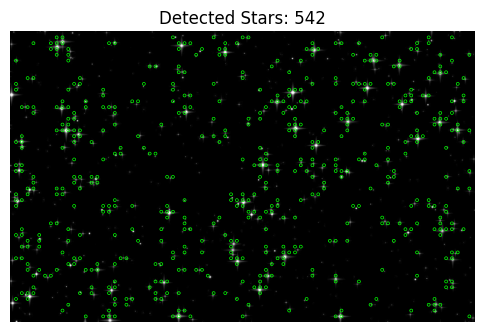

In [51]:
import matplotlib.pyplot as plt

# Check that full_image is valid
if full_image is None:
    raise ValueError("full_image is None — check image loading!")

# Plot the grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(full_image, cmap='gray')

# Draw circles on detected coordinates
for (x, y) in detected_coords:
    circle = plt.Circle((x, y), 4, color='lime', fill=False, linewidth=0.5)
    plt.gca().add_patch(circle)

# Final plot settings
plt.title(f"Detected Stars: {len(detected_coords)}")
plt.axis("off")
plt.show()


In [66]:
import os

# This will list all files in the current directory.
# 'index.html' should be in the output.
print(os.listdir('.'))

# This will check specifically for 'index.html' and print True or False.
print(os.path.exists('index.html'))

['.config', 'test7.jpg', 'kk.jpg', 'drive', 'index.html', 'sample_data']
True


In [ ]:
import base64
from PIL import Image
import io
import numpy as np

# Import the necessary libraries for your model
import tensorflow as tf
from tensorflow import keras

# === CRITICAL FIX: Make sure these imports are at the top of this cell ===
from IPython.display import display, HTML
from google.colab import output as colab_output
# =========================================================================

# =========================================================================
# 1. Your trained model and helper functions
# =========================================================================

# Step 1: Load your trained model here
# Replace 'your_model_path.h5' with the actual path to your model file
# (e.g., '/content/drive/MyDrive/star_counter_model.h5')
try:
    model = keras.models.load_model('your_model_path.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")
    model = None


def count_stars_with_model(image_array):
    """
    This function takes an image and uses your loaded model to predict the star count.

    You must replace the placeholder code below with your model's logic.
    """
    if model is None:
        print("Model not loaded. Cannot make a prediction.")
        return "Error"

    print("Running star counting model...")

    # === BEGIN: YOUR MODEL'S PREDICTION LOGIC HERE ===
    image = Image.fromarray(image_array)
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    star_count = int(np.round(prediction[0][0]))

    # === END: YOUR MODEL'S PREDICTION LOGIC HERE ===

    return star_count


def process_image_from_js(image_data_url):
    """Decodes the base64 image data from JavaScript into a numpy array."""
    base64_data = image_data_url.split(',')[1]
    decoded_image = base64.b64decode(base64_data)
    image = Image.open(io.BytesIO(decoded_image))
    image_array = np.array(image)

    return image_array


# =========================================================================
# 2. The Python function called by the front-end
# =========================================================================

def run_star_counter(image_data_url):
    """
    This function is called by the JavaScript `invokeFunction`.
    It receives the image, runs the model, and sends the result back.
    """
    try:
        image_array = process_image_from_js(image_data_url)
        star_count = count_stars_with_model(image_array)
        colab_output.eval_js(f'updateUIwithResult("{star_count}")')

    except Exception as e:
        print(f"An error occurred: {e}")
        colab_output.eval_js(f'handleError("{e}")')


# =========================================================================
# 3. The main function to display the UI and register the callback
# =========================================================================

def display_html_ui():
    """
    Reads the HTML file, registers the Python function, and displays the UI.
    """
    html_file = 'index.html'
    try:
        with open(html_file, 'r') as f:
            html_code = f.read()
    except FileNotFoundError:
        print("Error: 'index.html' not found. Please upload the file to your Colab session.")
        return

    colab_output.register_callback('run_star_counter', run_star_counter)
    display(HTML(html_code))

# =========================================================================
# 4. Start the UI
# =========================================================================
display_html_ui()

In [81]:
import base64
from PIL import Image
import io
import numpy as np

# Import the necessary libraries for your model
import tensorflow as tf
from tensorflow import keras

from IPython.display import display, HTML
from google.colab import output as colab_output

# =========================================================================
# 1. Your trained model and helper functions (WITH DEBUGGING)
# =========================================================================

# Step 1: Load your trained model here
# -------------------------------------------------------------------------
# Replace 'your_model_path.h5' with the correct path to your model file.
# This is the most common place for an error.
# -------------------------------------------------------------------------
model_path = '/content/drive/MyDrive/your_model_path.h5' # <--- VERIFY THIS PATH
try:
    model = keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load the model from {model_path}")
    print(f"The error was: {e}")
    model = None


def count_stars_with_model(image_array):
    """
    This function takes an image and uses your loaded model to predict the star count.

    You must replace the placeholder code below with your model's logic.
    """
    if model is None:
        return "Error: Model not loaded"

    try:
        print("Starting model prediction logic...")

        # === BEGIN: YOUR MODEL'S PREDICTION LOGIC HERE ===

        print(f"Original image shape: {image_array.shape}")

        image = Image.fromarray(image_array)
        image = image.resize((224, 224))

        # Check the image mode (e.g., 'RGB', 'L')
        print(f"Image mode after resize: {image.mode}")

        # Ensure the image has 3 channels if your model expects it
        if image.mode == 'L':
             image = image.convert('RGB')

        image = np.array(image) / 255.0

        # Check the shape again before feeding to the model
        print(f"Image shape before model prediction: {image.shape}")

        image = np.expand_dims(image, axis=0)

        print("Running model.predict()...")
        prediction = model.predict(image)
        print(f"Model prediction output: {prediction}")

        star_count = int(np.round(prediction[0][0]))

        print(f"Final predicted star count: {star_count}")

        # === END: YOUR MODEL'S PREDICTION LOGIC HERE ===

        return star_count

    except Exception as e:
        print(f"ERROR: An error occurred during model prediction: {e}")
        return "Error"


def process_image_from_js(image_data_url):
    """Decodes the base64 image data from JavaScript into a numpy array."""
    base64_data = image_data_url.split(',')[1]
    decoded_image = base64.b64decode(base64_data)
    image = Image.open(io.BytesIO(decoded_image))
    image_array = np.array(image)

    return image_array


# =========================================================================
# 2. The Python function called by the front-end (WITH DEBUGGING)
# =========================================================================

def run_star_counter(image_data_url):
    """
    This function is called by the JavaScript `invokeFunction`.
    It receives the image, runs the model, and sends the result back.
    """
    try:
        # Acknowledge that the call was successful
        print("\n--- Received call from front-end ---")

        image_array = process_image_from_js(image_data_url)
        star_count = count_stars_with_model(image_array)

        # Send the response back to the UI, even if it's an error message
        colab_output.eval_js(f'updateUIwithResult("{star_count}")')

    except Exception as e:
        print(f"ERROR: An unhandled error occurred in run_star_counter: {e}")
        # Send a clear error message to the front-end
        colab_output.eval_js(f'handleError("An unexpected error occurred.")')


# =========================================================================
# 3. The main function to display the UI and register the callback
# =========================================================================

def display_html_ui():
    """
    Reads the HTML file, registers the Python function, and displays the UI.
    """
    html_file = 'index.html'
    try:
        with open(html_file, 'r') as f:
            html_code = f.read()
    except FileNotFoundError:
        print("Error: 'index.html' not found. Please upload the file to your Colab session.")
        return

    colab_output.register_callback('run_star_counter', run_star_counter)
    display(HTML(html_code))


# =========================================================================
# 4. Start the UI
# =========================================================================
display_html_ui()

ERROR: Could not load the model from /content/drive/MyDrive/your_model_path.h5
The error was: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/your_model_path.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
